# Tarea para entrega
# Jorge Leonardo López Agredo 
    ## Código: 2218061 Fecha: 05_19_2021 
## Profesor: Ph.D. Juan Carlos Basto Pineda

Se presenta el siguiente problema:

# Informaciones para la tarea
## Qué se tiene:
1. Imágenes del telescopio hubble para 9 galaxias distintas: {3, 15, 37, ..., 1002}.
1. Para cada galaxia hay imágenes en 9 bandas distintas: {105, 125, 140, ... , 850}.
1. Para cada combinación (gal, band) hay también un mapa de pesos: weight map.
1. Para diferenciar entre imágenes y weight maops fijarse en el sufijo en los nombres de archivo:
- sci -> science image
- wht -> weight map

 **Observación** Las imágenes en distintas bandas tienen distintas resoluciones. Si modelamos el efecto de la óptica como la convolución con una gaussiana, equivale a decir que en cada banda ha habido una convolución con gaussianas de distintos anchos característicos.

### El ancho de la gaussiana, sigma, depende de la banda debido a la óptica del telescopio, no de la galaxia observada
Estos son los sigmas medidos en pixeles:
- "105":1.47,
- "125":1.49,
- "140":1.55,
- "160":1.56,
- "435":0.78,
- "606":0.95,
- "775":0.87,
- "814":0.91,
- "850":0.85

## Comenzamos importanto algunas librerías que vamos a utilizar en el desarrollo de este notebook.

In [1]:
import numpy as np
from astropy.io import fits
from numpy.fft import fftshift, rfft2, irfft2
from shutil import copyfile
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.interpolate
from scipy import interpolate
import pickle
import os
import sys
import matplotlib.pyplot as plt

## Vamos a crear nuestra clase base llamada *Galaxia*
En esta clase vamos a poder obtener los datos importantes de cada galaxia, como lo son, su nombre, el filtro con el que se tomó la imagen, el tipo de archivo que estamos estudiando (**'sci'**, **'wht'**), además del correspondiente valor de **sigma** asociado al filtro utilizado.

En esta clase, encontramos la oportunidad de optener el valor de `sigma` a partir del `filtro` con el cual fue observada la `galaxia estudiada`. Por otra parte, podemos importar los datos de la imagen, si conocemos el nombre de la `galaxia`, el número de `filtro` y el valor de una `bamdera` que puede ser $0$ o $1$, donde $0$ es si queremos acceder al archivo _sci_ o $1$ si queremos acceder al archivo _wht_. Finalmente, tenemos tres métodos estáticos, que nos permite acceder a los nombres de las  `posibles_galaxias`, los números de los `posibles_filtros`, y los dos `posibles_tipo_archivo` para poder `importar_imagen`.

In [64]:
class Galaxia(object):
    """ La galaxia es la imagen que estamos estudiando, importadas 
    
    
    
    """
    def __ini__(self):
        self.nombre_galaxia = 3
        self.numero_filtro = 105
        self.tipo_archivo = 'sci'
        self.sigma = 1.47
    
    def calculate_sigma(self, filtro):
        if filtro == 105:
            self.sigma =  1.47
        elif filtro == 125:
            self.sigma =  1.49
        elif filtro == 140:
            self.sigma =  1.55
        elif filtro == 160:
            self.sigma =  1.56
        elif filtro == 435:
            self.sigma =  0.78
        elif filtro == 606:
            self.sigma =  0.95
        elif filtro == 775:
            self.sigma =  0.87
        elif filtro == 814:
            self.sigma =  0.91
        elif filtro == 850:
            self.sigma =  0.85
        else:
            print("Error al seleccionar el filtro del telescopio.")
            pause
        self.numero_filtro = filtro
        return self.sigma
    
    def calculate_tipo_filtro(self, filtro):
        if filtro == 850:
            self.tipo_filtro = 'lp'
        else:
            self.tipo_filtro = 'w'
        self.numero_filtro = filtro
        return self.tipo_filtro
    
    def calculate_tipo_archivo(self, bandera):
        if bandera == 0:
            self.tipo_archivo = 'sci'
        elif bandera == 1:
            self.tipo_archivo = 'wht'
        return self.tipo_archivo
            
    def importar_imagen(self, galaxia, filtro, bandera):
        self.data = fits.open('./images_hubble/'+str(galaxia)+'_60mas_f'+str(filtro)+str(self.calculate_tipo_filtro(filtro))+
                         '_'+str(self.calculate_tipo_archivo(bandera))+'.fits')[0].data
        return self.data
    
    @staticmethod
    def posibles_galaxias():
        return [3, 15, 37, 912, 919, 937, 943, 982, 1002]
    
    @staticmethod
    def posibles_filtros():
        return [105, 125, 140, 160, 435, 606, 775, 814, 850]
    
    @staticmethod        
    def posibles_tipo_archivo():
        return ['sci', 'wht']

## Clase Principal

Nuestra clase Principal, es una subclase de la superclase Galaxia.

Creamos esta clase para poder hacer entre otras cosas, las convoluciones necesarias de una imagen, con una nueva `sigma`. Además, podemos igualar las resoluciones de dos filtros diferentes de una misma galaxia, calculando la `sigma_final` equivalente. Finalmente, podemos mostrar la imagen en pantalla de la galaxia, ya sea, la original  `data = data_sci`, la de los pesos `data = data_wht`, o la imagen convolucionada con la `sigma_final` equivalente, llamada `data = data_conv`; las cuales son propias de cada galaxia y filtro correspondiente.


In [65]:
class Principal(Galaxia):
    
    def __init__(self, galaxia, filtro):
        #super(Principal, self).__init__(filtro(filtro))
        self.nombre_galaxia = galaxia
        self.numero_filtro = filtro
        self.data_sci = self.importar_imagen(galaxia, filtro, 0 )
        self.data_wht = self.importar_imagen(galaxia, filtro, 1)
        self.sigma = self.calculate_sigma(filtro)
        self.tipo_filtro = self.calculate_tipo_filtro(filtro)
        self.varianza = 1/self.data_wht
      
    
    def direct_convolution(self, data,sigma,kernel_square=False):
        FWHM = sigma * (2 * np.sqrt(2 * np.log(2)))
        FWHM = np.int(FWHM)+1
        data2 = np.zeros((data.shape[0] + 2 * FWHM, data.shape[1] + 2 * FWHM))
        data2[FWHM:data.shape[0] + FWHM, FWHM:data.shape[1] + FWHM] = data
        y, x = np.indices((data2.shape))
        psf = (1. / (2 * np.pi * sigma ** 2)) * np.exp(-((x - data2.shape[1] / 2) ** 2 +
                                                         (y - data2.shape[0] / 2) ** 2) / (2.0 * sigma ** 2))
        psf /= psf.sum()  # normalisation PSF
        if kernel_square:
            psf = psf**2
        psf_shift = fftshift(psf)
        data_conv = irfft2(rfft2(data2) * rfft2(psf_shift))
        self.data_conv = data_conv[FWHM:data.shape[0] + FWHM, FWHM:data.shape[1] + FWHM]
        return self.data_conv
    
    def equate_resolutions(self, filtro1, filtro2):
        sigma1 = self.calculate_sigma(filtro1)
        sigma2 = self.calculate_sigma(filtro2)
        self.sigma_final = np.sqrt(np.abs(sigma1**2-sigma2**2))
        return self.sigma_final
    
    def mostrar_imagen(self,data):
        return plt.imshow(np.log10(data))
    
    
            
    

In [66]:
galaxia_1 = Galaxia()

In [67]:
galaxia_1.calculate_sigma(160)

1.56

In [69]:
galaxia_1.calculate_tipo_archivo(0)

'sci'

In [70]:
galaxia = Principal(3, 160)

In [71]:
galaxia.sigma

1.56

In [72]:
galaxia.direct_convolution(galaxia.data_sci, galaxia.sigma, False)

array([[1.54062061e-04, 2.64994530e-04, 3.61326398e-04, ...,
        6.33782384e-04, 4.68288543e-04, 2.97282471e-04],
       [1.11159934e-04, 2.33299969e-04, 3.62244513e-04, ...,
        8.20498599e-04, 6.02189311e-04, 3.80992502e-04],
       [2.76506201e-05, 1.33270241e-04, 2.78395726e-04, ...,
        9.28074060e-04, 6.81641643e-04, 4.37449373e-04],
       ...,
       [2.13143542e-04, 2.29526878e-04, 1.70832479e-04, ...,
        2.40264544e-03, 1.85747286e-03, 1.25832660e-03],
       [2.80031727e-04, 3.37802122e-04, 3.09127826e-04, ...,
        1.91956763e-03, 1.50103361e-03, 1.02477028e-03],
       [2.76840137e-04, 3.51911355e-04, 3.48379971e-04, ...,
        1.34847376e-03, 1.06070643e-03, 7.26482875e-04]])

In [73]:
galaxia.data_wht

array([[1253008.9, 1277002.5, 1300356.5, ..., 1253080.6, 1210240.4,
        1236647.9],
       [1246919. , 1297574.9, 1286220.2, ..., 1290028. , 1194738.2,
        1256749.4],
       [1294797.5, 1272056.4, 1255762.4, ..., 1242739.4, 1291084.9,
        1257625.9],
       ...,
       [1223000.9, 1257750.6, 1198383.1, ..., 1211168. , 1280035.5,
        1293776.4],
       [1238828.5, 1195469. , 1254039.5, ..., 1208715. , 1276739.6,
        1228014.1],
       [1245145.6, 1221083.9, 1249130.9, ..., 1322291.8, 1225711.5,
        1257073. ]], dtype=float32)

In [74]:
galaxia.data_sci

array([[ 6.0588302e-04,  1.1158418e-03,  1.0646536e-03, ...,
         1.3378209e-03,  8.8098331e-04,  8.2477997e-04],
       [-3.3854603e-04,  7.2459382e-04,  6.3303689e-04, ...,
         8.0264371e-04,  5.2641012e-04,  1.8974891e-04],
       [-7.4099813e-04, -5.7687434e-05, -4.3935532e-05, ...,
         1.2957642e-03,  7.8720920e-04,  1.1680541e-04],
       ...,
       [ 3.9465723e-04, -2.5122188e-04, -1.5193266e-04, ...,
         2.3122532e-03,  2.0254136e-03,  1.6808953e-03],
       [ 5.6971854e-04,  6.3739659e-04,  9.4994501e-04, ...,
         2.3474188e-03,  2.1389716e-03,  1.4649390e-03],
       [ 1.0391477e-03,  1.2483343e-03,  1.0353584e-03, ...,
         1.9277881e-03,  1.7537033e-03,  1.2241240e-03]], dtype=float32)

In [75]:
galaxia.equate_resolutions(105, 850)

1.1993331480451959

<ipython-input-65-54270073adb7>:37: RuntimeWarning: invalid value encountered in log10
  return plt.imshow(np.log10(data))


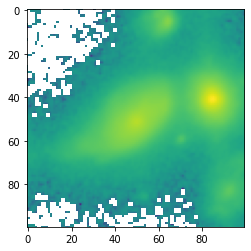

In [76]:
galaxia.mostrar_imagen(galaxia.data_sci)

In [77]:
galaxia.varianza

array([[7.9807893e-07, 7.8308381e-07, 7.6901989e-07, ..., 7.9803323e-07,
        8.2628213e-07, 8.0863765e-07],
       [8.0197674e-07, 7.7066846e-07, 7.7747183e-07, ..., 7.7517700e-07,
        8.3700343e-07, 7.9570361e-07],
       [7.7232153e-07, 7.8612868e-07, 7.9632900e-07, ..., 8.0467396e-07,
        7.7454240e-07, 7.9514905e-07],
       ...,
       [8.1766092e-07, 7.9507015e-07, 8.3445769e-07, ..., 8.2564929e-07,
        7.8122832e-07, 7.7293112e-07],
       [8.0721424e-07, 8.3649178e-07, 7.9742307e-07, ..., 8.2732487e-07,
        7.8324507e-07, 8.1432290e-07],
       [8.0311889e-07, 8.1894456e-07, 8.0055662e-07, ..., 7.5626275e-07,
        8.1585267e-07, 7.9549875e-07]], dtype=float32)

In [78]:
galaxia.

3